In [128]:
import torch
import espaloma as esp

In [145]:
class EulerIntegrator(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, m=0.1):
        defaults = dict(
            lr=lr,
            m=m,
        )
        super(EulerIntegrator, self).__init__(params, defaults)
    
    # @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for q in group['params']:
                if q.grad is None:
                    continue

                state = self.state[q]
                if len(state) == 0:
                    state['p'] = torch.zeros_like(q)

                state['p'].add(q.grad, alpha=-group['lr']*group['m'])
                q.add(state['p'], alpha=group['lr'])

        return loss


In [146]:
class NodeRNN(torch.nn.Module):
    def __init__(self, input_size=32, units=128):
        super(NodeRNN, self).__init__()
        self.rnn = torch.nn.RNN(
            input_size=input_size,
            hidden_size=units,
            batch_first=True,
            bidirectional=True,
        )
        self.d = torch.nn.Linear(
            2 * units,
            1
        )
    
    def forward(self, g, windows=48):
        g.apply_nodes(
            lambda node: {'lambs_': self.d(self.rnn(node.data['h'][:, None, :].repeat(1, windows, 1))[0]).squeeze(-1)},
            ntype='n2'
        )
        
        g.apply_nodes(
            lambda node: {'lambs_': self.d(self.rnn(node.data['h'][:, None, :].repeat(1, windows, 1))[0]).squeeze(-1)},
            ntype='n3'
        )
        
        return g
        

In [167]:
class LambdaConstraint(torch.nn.Module):
    def __init__(self):
        super(LambdaConstraint, self).__init__()
        
    def forward(self, g):
        g.apply_nodes(
            lambda node: {'lambs': node.data['lambs_'].softmax(dim=-1).cumsum(dim=-1)},
            ntype='n2'
        )
        
        g.apply_nodes(
            lambda node: {'lambs': node.data['lambs_'].softmax(dim=-1).cumsum(dim=-1)},
            ntype='n3'
        )
        
        return g

In [168]:
g = esp.Graph('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')
esp.graphs.LegacyForceField('smirnoff99Frosst').parametrize(g)


In [169]:
layer = esp.nn.dgl_legacy.gn()

representation = esp.nn.Sequential(
    layer,
    [32, 'tanh', 32, 'tanh', 32, 'tanh'],
)

readout = esp.nn.readout.janossy.JanossyPooling(
    in_features=32,
    config=[32, 'tanh', 32],
    out_features={
        1: {'h': 32},
        2: {'h': 32},
        3: {'h': 32},
    }
)

node_rnn = NodeRNN()

lambda_constraint = LambdaConstraint()

net = torch.nn.Sequential(
    representation,
    readout,
    node_rnn,
    lambda_constraint,
)

In [170]:
def f(x, idx):
    if idx == 0:
        return (x ** 2).sum(dim=(0, 2))
    
    if idx == 49:
        g.nodes['n1'].data['xyz'] = x
        esp.mm.geometry.geometry_in_graph(g.heterograph)
        esp.mm.energy.energy_in_graph(g.heterograph, suffix='_ref')
        # print(g.nodes['n2'].data['u'].sum(dim=0) + g.nodes['n3'].data['u'].sum(dim=0))
        return 1e-10 * (g.nodes['n2'].data['u_ref'].sum(dim=0) + g.nodes['n3'].data['u_ref'].sum(dim=0))

    g.nodes['n1'].data['xyz'] = x
    esp.mm.geometry.geometry_in_graph(g.heterograph)
    esp.mm.energy.energy_in_graph(g.heterograph, suffix='_ref')

    g.heterograph.apply_nodes(
        lambda node: {'u': node.data['u_ref'] * node.data['lambs'][:, idx-1][:, None]},
        ntype='n2'
    )

    g.heterograph.apply_nodes(
        lambda node: {'u': node.data['u_ref'] * node.data['lambs'][:, idx-1][:, None]},
        ntype='n3'
    )

    return 1e-10 * (g.nodes['n2'].data['u'].sum(dim=0) + g.nodes['n3'].data['u'].sum(dim=0))



In [171]:
def loss():
    x = torch.nn.Parameter(
        torch.randn(
            g.heterograph.number_of_nodes('n1'),
            128,
            3
        )
    )
    
    sampler = EulerIntegrator([x], 1e-1)
    
    works = 0.0
    
    net(g.heterograph)
    
    for idx in range(1, 50):
        sampler.zero_grad()
        energy_old = f(x, idx-1)
        energy_new = f(x, idx)
        energy_new.sum().backward(create_graph=True)
        sampler.step()
        works += energy_new - energy_old
        
    return works.sum()


In [171]:
optimizer = torch.optim.SGD(net.parameters(), 1e-2, 1e-2)
for _ in range(1000):
    optimizer.zero_grad()
    _loss = loss()
    _loss.backward()
    print(_loss)
    print(g.nodes['n2'].data['lambs_'][0].detach())
    optimizer.step()

KeyboardInterrupt: 

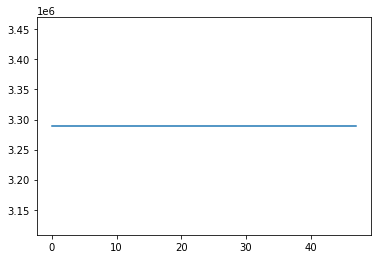

In [140]:
from matplotlib import pyplot as plt
plt.plot(g.nodes['n2'].data['lambs_'][0].detach())
